Load dependencies

In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sys
from pathlib import Path
# sys.path.append(str(Path(__file__).resolve().parent.parent / "processed_data"))
root_dir = Path.cwd().parent
# Import data from warehouse
# Paths to CSV files in data_warehouse
categories = root_dir / "data_warehouse" / "processed_data" / "dim_categories.csv"
customers = root_dir / "data_warehouse" / "processed_data" / "dim_customers.csv"
dates = root_dir / "data_warehouse" / "processed_data" / "dim_dates.csv"
currencies = root_dir / "data_warehouse" / "processed_data" / "dim_currencies.csv"
transactions = root_dir / "data_warehouse" / "processed_data" / "fact_transactions.csv"

Load data

In [10]:
fact_transactions = pd.read_csv(transactions)
dim_categories = pd.read_csv(categories)
dim_currencies = pd.read_csv(currencies)
dim_customers = pd.read_csv(customers)
dim_dates = pd.read_csv(dates)

Merge fact to dimension tables

In [11]:
# Join the Static dimension
fact_enriched = (
    fact_transactions
    .merge(dim_categories, on="category_key", how="left", validate="many_to_one")
    .merge(dim_currencies, on="currency_key", how="left", validate="many_to_one")
    .merge(dim_dates, on="date_key", how="left", validate="many_to_one")
)

# Quality check - Enforce date types
fact_enriched["date"] = pd.to_datetime(fact_enriched["date"])
dim_customers["effective_from"] = pd.to_datetime(dim_customers["effective_from"])
dim_customers["effective_to"] = pd.to_datetime(dim_customers["effective_to"])

# Join the SCD Type-2 custmomer table
fact_customer_joined = fact_enriched.merge(
    dim_customers,
    on="customer_id",
    how="left",
    validate="many_to_many"
)

# Replacing missing effective_to so time-range joined against facts treats it as an active version
fact_customer_joined["effective_to"] = (
    fact_customer_joined["effective_to"]
    .fillna(pd.Timestamp("2099-12-31"))
)

# Filter valid SCD2 customer record ----
business_data = fact_customer_joined[
    (fact_customer_joined["date"] >= fact_customer_joined["effective_from"]) &
    (fact_customer_joined["date"] <= fact_customer_joined["effective_to"])
]

# Quality check
assert business_data.groupby("transaction_id").size().max() == 1


In [12]:
# Check the colmns
business_data.columns

Index(['transaction_id', 'transaction_key', 'customer_id', 'customer_key_x',
       'currency_key', 'category_key', 'date_key', 'transaction_timestamp_x',
       'transaction_amount_eur', 'current_exchange_rate',
       'is_high_value_transaction', 'category', 'is_refundable',
       'return_window_days', 'transaction_timestamp_y', 'base_currency',
       'transaction_currency', 'currency_imputed', 'conversion_type',
       'transaction_timestamp', 'exchange_rate_source', 'date',
       'transaction_day', 'transaction_month', 'transaction_month_name',
       'transaction_year', 'transaction_weekday', 'customer_key_y', 'country',
       'signup_date', 'effective_from', 'effective_to', 'is_current'],
      dtype='str')

In [13]:
# Drop the columns that are not needed
business_data = (
    business_data
        .drop(columns=[
            "transaction_timestamp",
            "transaction_timestamp_y",
            "customer_key_x"
        ])
        .rename(columns={
            "transaction_timestamp_x": "transaction_timestamp",
            "customer_key_y": "customer_key"
        })
)

In [14]:
# Read data information
business_data.info()

<class 'pandas.DataFrame'>
Index: 35952 entries, 5 to 119965
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   transaction_id             35952 non-null  int64         
 1   transaction_key            35952 non-null  int64         
 2   customer_id                35952 non-null  int64         
 3   currency_key               35952 non-null  int64         
 4   category_key               35952 non-null  int64         
 5   date_key                   35952 non-null  int64         
 6   transaction_timestamp      35952 non-null  str           
 7   transaction_amount_eur     35952 non-null  float64       
 8   current_exchange_rate      35952 non-null  float64       
 9   is_high_value_transaction  35952 non-null  int64         
 10  category                   35952 non-null  str           
 11  is_refundable              35952 non-null  bool          
 12  return_window_days 

In [15]:
# Collect numerical columns for descriptive statistics
numerical_columns = [
    'transaction_amount_eur',
    'current_exchange_rate',
    'return_window_days',
    'transaction_day',
    'transaction_month',
    'transaction_year'
]

In [16]:
# Perform descriptive statistics on numerical columns
descriptive_stats = business_data[numerical_columns].describe()
print(descriptive_stats)

       transaction_amount_eur  current_exchange_rate  return_window_days  \
count            35952.000000           35952.000000        35952.000000   
mean                63.580165               0.637677           10.089286   
std                 54.207298               0.444893           14.173584   
min                -43.890000               0.087870            0.000000   
25%                 10.110000               0.094960            0.000000   
50%                 61.025000               1.000000            0.000000   
75%                107.870000               1.000000           30.000000   
max                263.110000               1.000000           30.000000   

       transaction_day  transaction_month  transaction_year  
count     35952.000000       35952.000000           35952.0  
mean         15.463034           6.822931            2020.0  
std           8.839960           3.237310               0.0  
min           1.000000           1.000000            2020.0  
25%  

The typical transaction amount is around €63.58, and transactions are spread fairly evenly across the days of the month, with an average day being the 15th. The distribution also shows that all transactions in this dataset occurred within the year 2020.

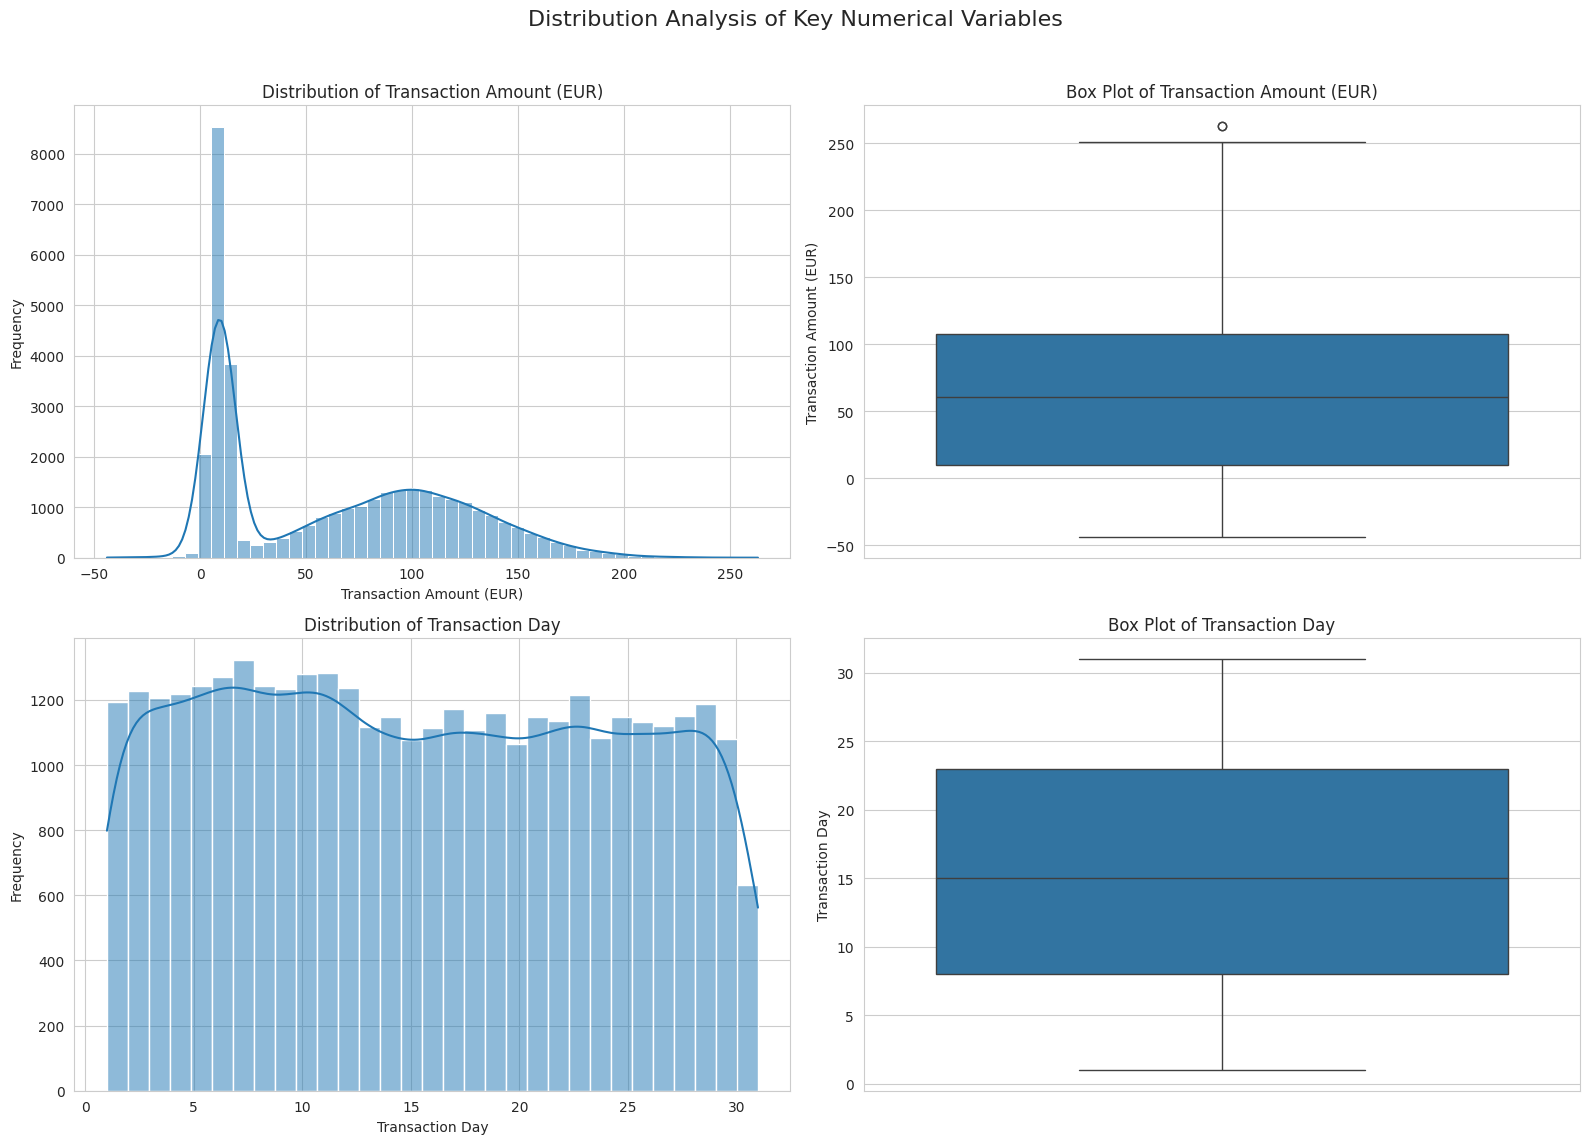

In [17]:
# Plot distribution

# Set up the plotting style
sns.set_style("whitegrid")

# Create subplots for better organization
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('Distribution Analysis of Key Numerical Variables', fontsize=16)

# 1. Histogram for 'transaction_amount_eur'
sns.histplot(business_data['transaction_amount_eur'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Transaction Amount (EUR)')
axes[0, 0].set_xlabel('Transaction Amount (EUR)')
axes[0, 0].set_ylabel('Frequency')

# 2. Box Plot for 'transaction_amount_eur'
sns.boxplot(y=business_data['transaction_amount_eur'], ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Transaction Amount (EUR)')
axes[0, 1].set_ylabel('Transaction Amount (EUR)')

# 3. Histogram for 'transaction_day'
sns.histplot(business_data['transaction_day'], bins=31, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Transaction Day')
axes[1, 0].set_xlabel('Transaction Day')
axes[1, 0].set_ylabel('Frequency')

# 4. Box Plot for 'transaction_day'
sns.boxplot(y=business_data['transaction_day'], ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of Transaction Day')
axes[1, 1].set_ylabel('Transaction Day')

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent suptitle overlap
plt.show()

- The histogram of transaction amount shows a right-skewed distribution, meaning a large number of transactions are coming with not as much spend
- The histogram for transaction_day appears relatively uniform, indicating that transactions are spread fairly evenly across the days of the month. The box plot (transaction day) confirms this uniformity, with the median close to the center and a consistent spread, reinforcing that transaction activity is quite consistent throughout the month.


Aggregating data by month and year for time-series analysis


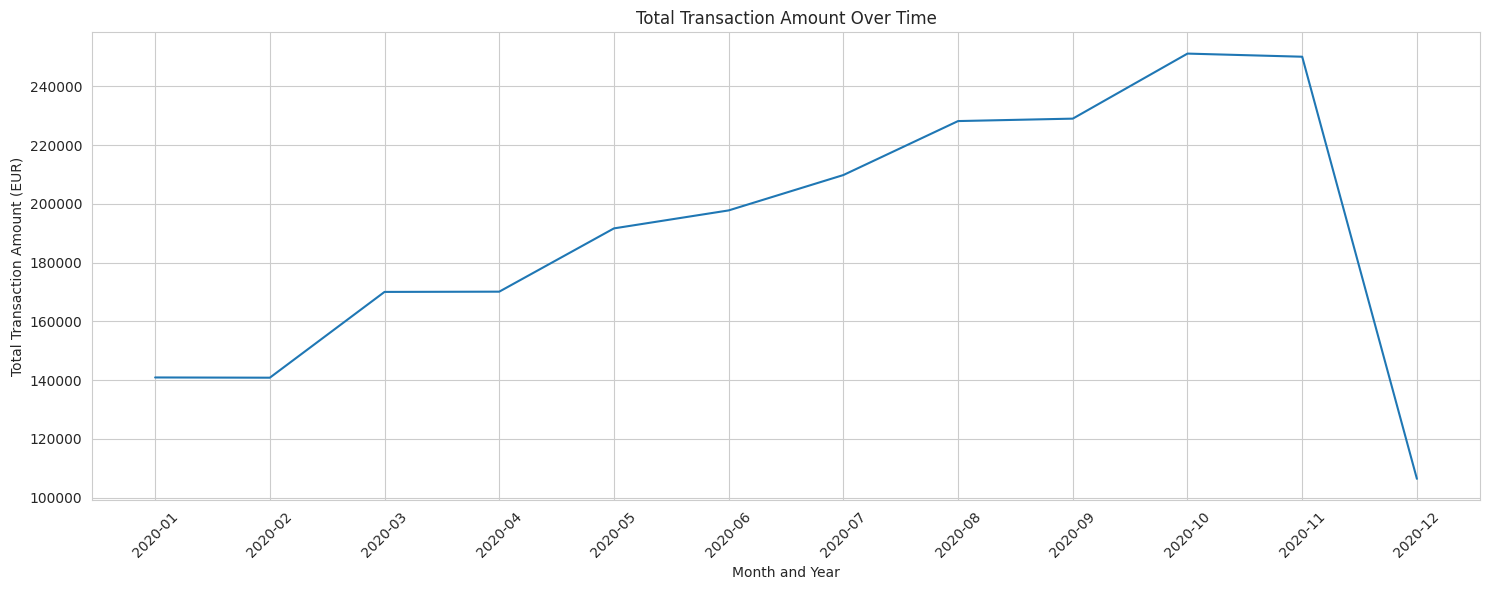

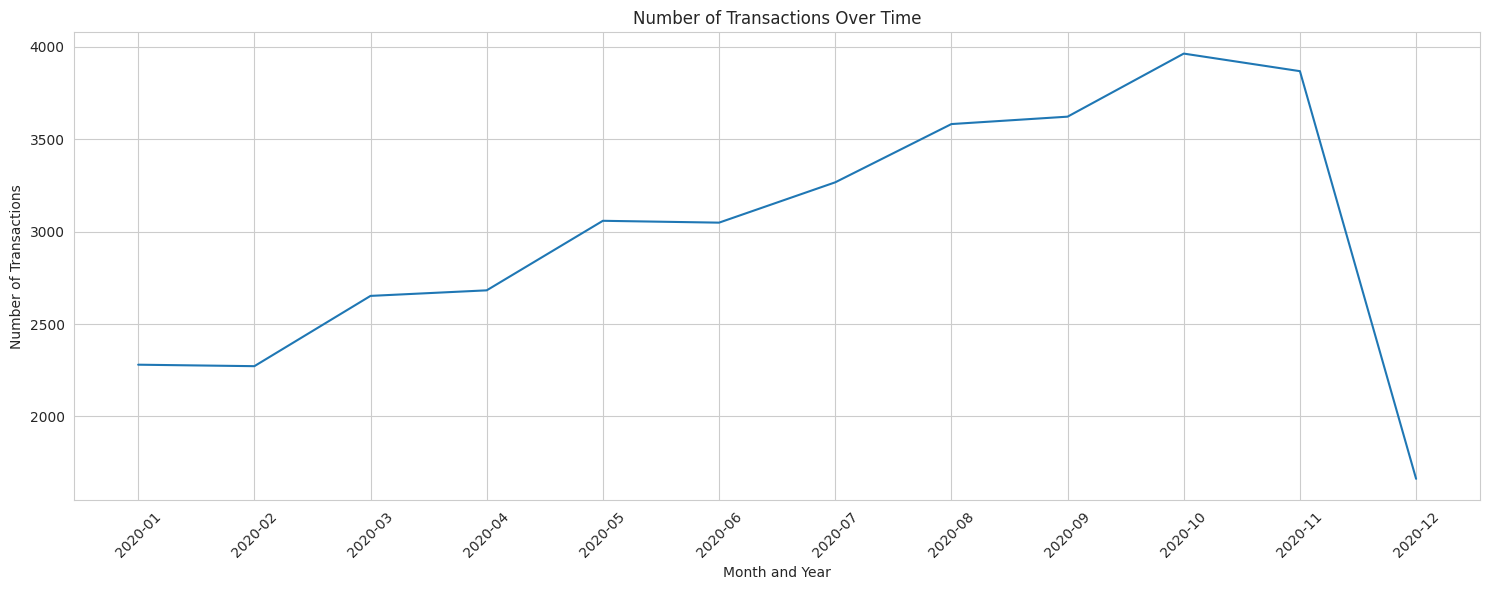

Time-series analysis completed, plots displayed.


In [18]:
print("Aggregating data by month and year for time-series analysis")
# Aggregate data by year and month
transaction_trends = business_data.groupby(['transaction_year', 'transaction_month']).agg(
    total_transaction_amount_eur=('transaction_amount_eur', 'sum'),
    number_of_transactions=('transaction_id', 'count')
).reset_index()

# Create a time period string for better plotting
transaction_trends['year_month'] = transaction_trends['transaction_year'].astype(str) + '-' + \
                                 transaction_trends['transaction_month'].astype(str).str.zfill(2)

# Ensure the time period is sorted correctly
transaction_trends = transaction_trends.sort_values(by='year_month')

# Plotting total transaction amount over time
plt.figure(figsize=(15, 6))
sns.lineplot(x='year_month', y='total_transaction_amount_eur', data=transaction_trends)
plt.title('Total Transaction Amount Over Time')
plt.xlabel('Month and Year')
plt.ylabel('Total Transaction Amount (EUR)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting number of transactions over time
plt.figure(figsize=(15, 6))
sns.lineplot(x='year_month', y='number_of_transactions', data=transaction_trends)
plt.title('Number of Transactions Over Time')
plt.xlabel('Month and Year')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time-series analysis completed, plots displayed.")

- Overall, the total transaction amount shows an upward trend throughout 2020 before the sharp dip between November and December. Beforehand, there's a noticeable neutrality between January and February, followed by a steady increase that peaks towards the end of the year, suggesting customer engagement and increased spending over time..

- The number of transactions also followed suit, suggesting a positive inverse correlation between the total number of transactions and the number of transactions over time.


Perform descriptive analysis on the customers' behaviour

In [19]:
# Aggregate the customers
customer_features = business_data.groupby('customer_id').agg(
    total_transaction_amount_eur=('transaction_amount_eur', 'sum'),
    number_of_transactions=('transaction_id', 'count'),
    average_transaction_amount_eur=('transaction_amount_eur', 'mean'),
).reset_index()

print("\nDescriptive statistics of customer_features DataFrame:")
print(customer_features.describe())


Descriptive statistics of customer_features DataFrame:
       customer_id  total_transaction_amount_eur  number_of_transactions  \
count  1924.000000                   1924.000000             1924.000000   
mean   2541.594595                   1188.063467               18.686071   
std    1439.456924                    575.466615                8.431375   
min       5.000000                      1.760000                1.000000   
25%    1321.750000                    789.340000               13.000000   
50%    2547.500000                   1233.115000               20.000000   
75%    3791.250000                   1594.920000               25.000000   
max    4999.000000                   3191.640000               41.000000   

       average_transaction_amount_eur  
count                     1924.000000  
mean                        64.055518  
std                         16.832368  
min                          1.760000  
25%                         54.626151  
50%                

/tmp/ipykernel_27568/2855381444.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


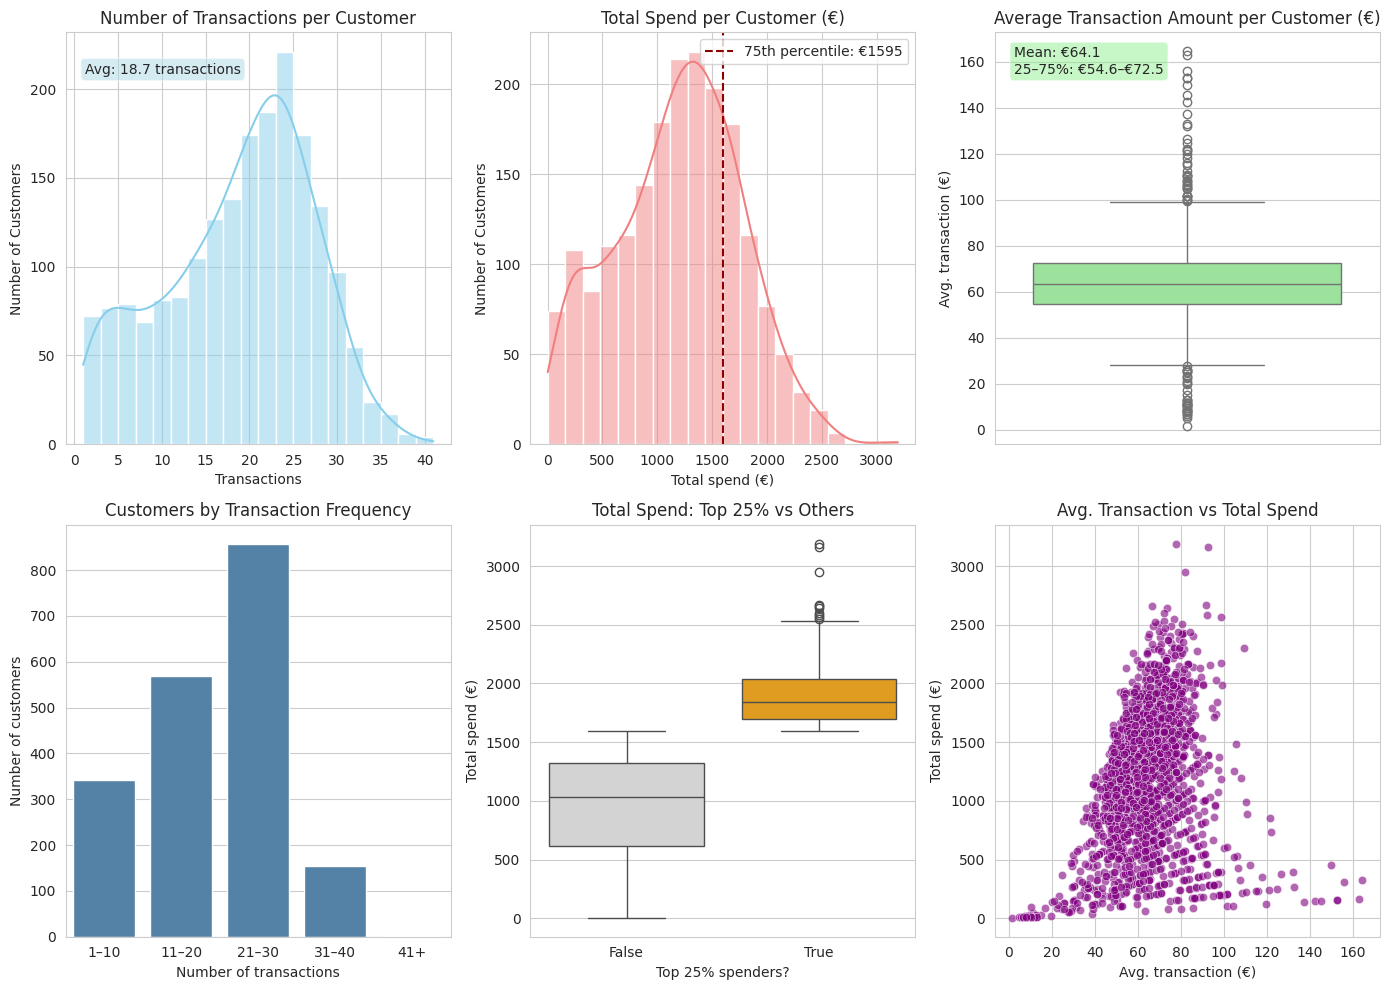

In [20]:
# Visualize the descriptive analysis on customer behaviour

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

# 1. Number of transactions per customer (engagement)
plt.subplot(2, 3, 1)
sns.histplot(customer_features["number_of_transactions"], bins=20, kde=True, color="skyblue")
plt.title("Number of Transactions per Customer")
plt.xlabel("Transactions")
plt.ylabel("Number of Customers")

# KPI text box for avg transactions
avg_trans = customer_features["number_of_transactions"].mean()
plt.text(
    0.05, 0.9, f"Avg: {avg_trans:.1f} transactions",
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.5)
)

# 2. Total spend per customer (revenue concentration)
plt.subplot(2, 3, 2)
sns.histplot(customer_features["total_transaction_amount_eur"], bins=20, kde=True, color="lightcoral")
plt.title("Total Spend per Customer (€)")
plt.xlabel("Total spend (€)")
plt.ylabel("Number of Customers")

# Add 75th percentile line
p75 = np.percentile(customer_features["total_transaction_amount_eur"], 75)
plt.axvline(p75, color="darkred", linestyle="--", label=f"75th percentile: €{p75:.0f}")
plt.legend()

# 3. Average transaction amount per customer (basket size)
plt.subplot(2, 3, 3)
sns.boxplot(y=customer_features["average_transaction_amount_eur"], color="lightgreen")
plt.title("Average Transaction Amount per Customer (€)")
plt.ylabel("Avg. transaction (€)")

# Add key stats as text
mean_avg = customer_features["average_transaction_amount_eur"].mean()
q25, q75 = np.percentile(customer_features["average_transaction_amount_eur"], [25, 75])
plt.text(
    0.05, 0.9, f"Mean: €{mean_avg:.1f}\n25–75%: €{q25:.1f}–€{q75:.1f}",
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.5)
)

# 4. Binned transaction counts (engagement focus)
plt.subplot(2, 3, 4)
bins = [0, 10, 20, 30, 40, 50]
labels = ["1–10", "11–20", "21–30", "31–40", "41+"]
binned = pd.cut(customer_features["number_of_transactions"], bins=bins, labels=labels, right=False)
sns.countplot(x=binned, color="steelblue")
plt.title("Customers by Transaction Frequency")
plt.xlabel("Number of transactions")
plt.ylabel("Number of customers")
plt.xticks(rotation=0)

# 5. High‑value customers vs rest (revenue concentration)
plt.subplot(2, 3, 5)
customer_features["is_top_25"] = customer_features["total_transaction_amount_eur"] >= p75
sns.boxplot(
    x="is_top_25",
    y="total_transaction_amount_eur",
    data=customer_features,
    palette=["lightgray", "orange"]
)
plt.title("Total Spend: Top 25% vs Others")
plt.xlabel("Top 25% spenders?")
plt.ylabel("Total spend (€)")

# 6. Average transaction amount vs total spend (strategy)
plt.subplot(2, 3, 6)
sns.scatterplot(
    x="average_transaction_amount_eur",
    y="total_transaction_amount_eur",
    data=customer_features,
    alpha=0.6,
    color="purple"
)
plt.title("Avg. Transaction vs Total Spend")
plt.xlabel("Avg. transaction (€)")
plt.ylabel("Total spend (€)")

plt.tight_layout()
plt.show()


Customer Purchase Behavior Report
The descriptive analysis for 1,924 customers' purchase behaviors:
- Number of Transactions per Customer (top left)
Shows a distribution centered around about 19 transactions, with most customers between roughly 13 and 25 transactions.The smooth density curve and the annotation “Avg: 18.7 transactions” make it clear that many customers buy multiple times rather than just once.The long right tail up to 40+ transactions visually highlights a smaller group of very frequent buyers.

- Total Spend per Customer (top middle): visually supports the revenue concentration outlook. The total spend distribution is right skewed: many customers between roughly €500 and €1,800, and fewer very high spend outliers. The dashed vertical line at the 75th percentile (≈€1,595) obviously shows where “top spenders” begin.. You can see that there is a noticeable mass of customers to the right of that line, but not nearly as many as in the main bulk of the distribution.

- Average Transaction Amount per Customer (top right) underpins our purchase business strategy angle. The box plot shows a median average transaction of around €63–€64, with the interquartile range roughly €55–€72, where Most customers cluster in that moderate band, as corroborated by the green annotation, with some outliers at higher average basket values up to around €160 representing a few customers who spend much more per purchase.

- Customers by Transaction Frequency (bottom left): shows how most customers fall in the middle groups, making between 11 and 30 purchases. Fewer customers are in the 1–10 purchases group, indicating a rarity of one-time or very occasional shoppers. There is still a visible small group to the far right making more than 30 purchases, supporting the outlier insights from the box-plot on the top right corner.

- Total Spend: Top 25% vs Others (bottom middle):: creates insight to focus incentives on top customers such as loyalty programs, VIP campaigns, and personalized offers.It shows two side-by-side box plots, indicating disparities in customer spend tendencies
The median and upper quartile for the top 25% group sit far above those of the non-top group, and there are high outliers around €2,500–€3,000+. This visual gap makes it easy see that our VIP segment spends dramatically more per person.

- Avg. Transaction vs Total Spend (bottom right): Here, the scatter plot shows an upward trend: customers with higher average transaction amounts generally have higher total spend, though with some spread. There is a dense cluster around €50–€80 average transaction and €800–€2,000 total spend, which looks like our core revenue-driving group highlighted from the boxplot at the bottom middle bottom



Perform customer segmentation

In [21]:

# Select features for clustering: spending + frequency
X = customer_features[["total_transaction_amount_eur",
                       "number_of_transactions"]].copy()

# Scale features for Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Fit KMeans with an assumed cluster of 4
kmeans = KMeans(
    n_clusters=4,
    init="k-means++",
    n_init=10,
    max_iter=300,
    random_state=42
)

customer_features["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

# Inspect cluster profiles
cluster_summary = (
    customer_features
    .groupby("kmeans_cluster")[["total_transaction_amount_eur",
                                "number_of_transactions",
                                "average_transaction_amount_eur"]]
    .mean()
    .round(2)
)

print(cluster_summary)


                total_transaction_amount_eur  number_of_transactions  \
kmeans_cluster                                                         
0                                     321.22                    5.25   
1                                    1378.47                   22.33   
2                                    1943.19                   28.71   
3                                     899.97                   14.61   

                average_transaction_amount_eur  
kmeans_cluster                                  
0                                        63.68  
1                                        62.53  
2                                        68.30  
3                                        63.04  


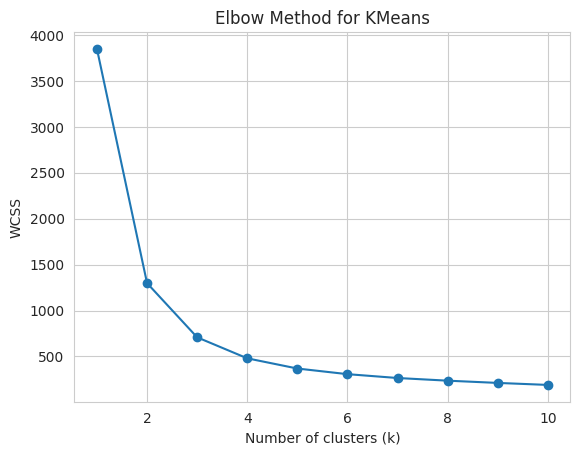

In [22]:
# Scan for a more reliable cluster number using the Elbow method
wcss = []
for k in range(1, 11):
    km = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=42
    )
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.plot(range(1, 11), wcss, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for KMeans")
plt.show()

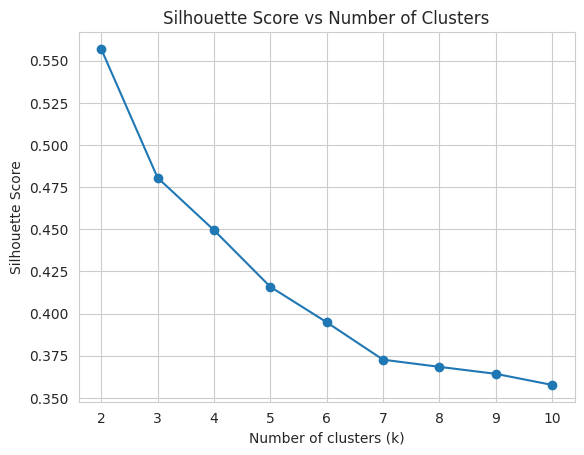

In [23]:
# Elbow steeps at 2 but validate clusters with silhouette_score

silhouette_scores = []

K = range(2, 11)  # silhouette not defined for k=1
for k in K:
    km = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=42
    )
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.plot(K, silhouette_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.show()


Elbow measures compactness as WCSS always decreases as k increases. So, at 2, it gives a big improvement, but after that, improvement slows but doesn’t disappear. Whereas Silhouette Score measures both - how close the points are within a cluster, and also how far from each other.So, ultimately, Clusters are more separated and cleaner at k = 3 than k = 2

In [24]:
optimal_k = 3

kmeans = KMeans(
    n_clusters=optimal_k,
    init="k-means++",
    n_init=10,
    max_iter=300,
    random_state=42
)

customer_features["cluster"] = kmeans.fit_predict(X_scaled)


In [25]:
# Visualize customer segments
cluster_summary = customer_features.groupby("cluster").agg(
    customers=("customer_id", "count"),
    avg_total_spend=("total_transaction_amount_eur", "mean"),
    avg_num_transactions=("number_of_transactions", "mean"),
    avg_transaction_value=("average_transaction_amount_eur", "mean")
).reset_index()

cluster_summary


,cluster,customers,avg_total_spend,avg_num_transactions,avg_transaction_value
0,0,787,1164.775006,19.013977,62.385582
1,1,492,433.011341,7.091463,63.413594
2,2,645,1792.425736,27.130233,66.582753


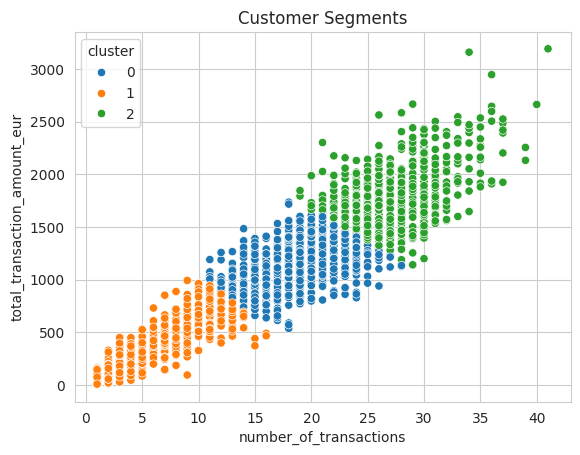

In [26]:
# Visualize the clusters

sns.scatterplot(
    data=customer_features,
    x="number_of_transactions",
    y="total_transaction_amount_eur",
    hue="cluster",
    palette="tab10"
)
plt.title("Customer Segments")
plt.show()


We drill through the product category preference for each customer segment for targeted marketing and insights for business improvement

In [27]:
# Merge customer features backk to the business data
segmented_data = business_data.merge(
    customer_features[["customer_id", "cluster"]],
    on="customer_id",
    how="inner"
)

In [28]:
segmented_data.head(2)

,transaction_id,transaction_key,customer_id,currency_key,category_key,date_key,transaction_timestamp,transaction_amount_eur,current_exchange_rate,is_high_value_transaction,...,transaction_month_name,transaction_year,transaction_weekday,customer_key,country,signup_date,effective_from,effective_to,is_current,cluster
0,89977,6,2905,2,1,1,2020-01-01 00:37:00,9.40,0.09496,0,...,Jan,2020,Wed,631,FI,2019-08-13,2019-08-13,2099-12-31,True,0
1,85879,21,4504,1,1,1,2020-01-01 01:33:00,48.91,1.00000,0,...,Jan,2020,Wed,58,SE,2019-01-21,2019-01-21,2099-12-31,True,2


In [29]:
# Check what categories are most popular in each cluster
category_pref_counts = (
    segmented_data
    .groupby(["cluster", "category"])
    .agg(
        transaction_count=("transaction_id", "count"),
        total_revenue=("transaction_amount_eur", "sum")
    )
    .reset_index()
)


In [30]:
category_pref_counts.head()

,cluster,category,transaction_count,total_revenue
0,0,Electronics,4976,306698.81
1,0,Food,5090,312673.81
2,0,unknown,4898,297305.31
3,1,Electronics,1215,72403.37
4,1,Food,1163,71311.10


In [31]:
# Normalize within each cluster to avoid bias wich comes with uneven cluster sizes
category_pref_counts["transaction_share"] = (
    category_pref_counts["transaction_count"] /
    category_pref_counts.groupby("cluster")["transaction_count"].transform("sum")
)


In [32]:
print("Transaction share")
category_pref_counts.head()

Transaction share


,cluster,category,transaction_count,total_revenue,transaction_share
0,0,Electronics,4976,306698.81,0.332531
1,0,Food,5090,312673.81,0.340150
2,0,unknown,4898,297305.31,0.327319
3,1,Electronics,1215,72403.37,0.348237
4,1,Food,1163,71311.10,0.333333


In [33]:
# Calculate the revenue share
category_pref_counts["revenue_share"] = (
    category_pref_counts["total_revenue"] /
    category_pref_counts.groupby("cluster")["total_revenue"].transform("sum")
)

In [34]:
print("Revenue share")
category_pref_counts.head()

Revenue share


,cluster,category,transaction_count,total_revenue,transaction_share,revenue_share
0,0,Electronics,4976,306698.81,0.332531,0.334576
1,0,Food,5090,312673.81,0.340150,0.341095
2,0,unknown,4898,297305.31,0.327319,0.324329
3,1,Electronics,1215,72403.37,0.348237,0.339856
4,1,Food,1163,71311.10,0.333333,0.334729


In [35]:
# Calculate Top 2 categories by transaction share
top_categories = (
    category_pref_counts
    .sort_values(["cluster", "transaction_share"], ascending=[True, False])
    .groupby("cluster")
    .head(2)
)

top_categories[[
    "cluster",
    "category",
    "transaction_count",
    "transaction_share",
    "revenue_share"
]]


,cluster,category,transaction_count,transaction_share,revenue_share
1,0,Food,5090,0.340150,0.341095
0,0,Electronics,4976,0.332531,0.334576
3,1,Electronics,1215,0.348237,0.339856
4,1,Food,1163,0.333333,0.334729
6,2,Electronics,5900,0.337162,0.335337
7,2,Food,5826,0.332933,0.330927


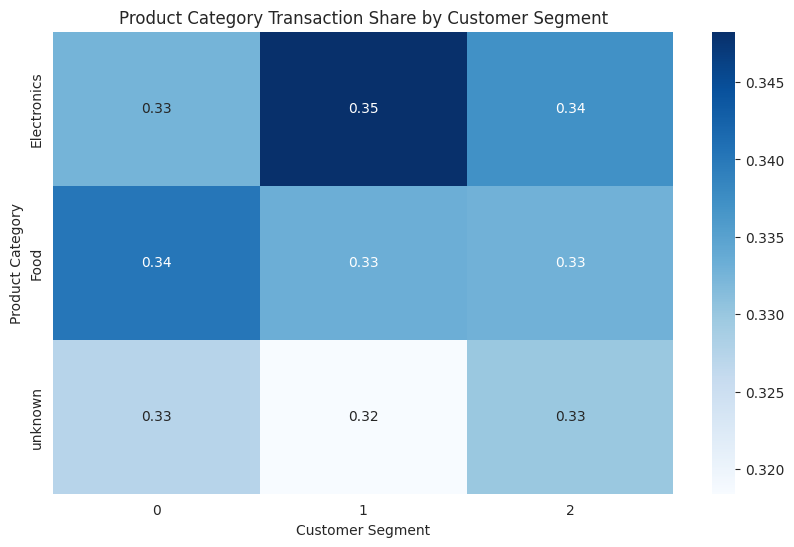

In [36]:
# Visualize category preference by segment

pivot_txn = category_pref_counts.pivot(
    index="category",
    columns="cluster",
    values="transaction_share"
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_txn, cmap="Blues", annot=True, fmt=".2f")
plt.title("Product Category Transaction Share by Customer Segment")
plt.ylabel("Product Category")
plt.xlabel("Customer Segment")
plt.show()


INSIGHTS AND RECOMMENDATIONS

The depth of color on the heatmap shows the order in which our customers imbibe a preference for our product categories.
- Clearly, our highest spenders at cluster 2 prefer Electronics and are doing quite well with the food category -almost on equal terms. They aren’t the highest of all categories, but are more evenly distributed in loyalty across our product categories.
- Our second performing customers at cluster O tend to do more on the food (the highest of all 3 clusters) side than electronics.
- The lowest segment of performance, the cluster 1 customers seem to show the highest level of purchase of electronics than the other cluster customer segments, and interestingly, at parity with cluster 2 customers on food
- For the cluster 3 customer, also known as high-value customers, I’d recommend exclusive pricing on premium Electronics to foster retention and optimize revenue.
- For the regular customers in cluster 0, I’d recommend engaging in Electronics loyalty points, like buy 3 Food items and free shipping" bundles
- And for the cluster 1 customers, d recommend 20% off Food on next purchase and support with an email series with Food recommendations
